In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, f1_score
import numpy as np
import xgboost as xgb
from math import pi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
filepath = r"mimic3d.csv"
df = pd.read_csv(filepath)

In [54]:
df.head(3)

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hadm_id           58976 non-null  int64  
 1   gender            58976 non-null  object 
 2   age               58976 non-null  int64  
 3   LOSdays           58976 non-null  float64
 4   admit_type        58976 non-null  object 
 5   admit_location    58976 non-null  object 
 6   AdmitDiagnosis    58951 non-null  object 
 7   insurance         58976 non-null  object 
 8   religion          58518 non-null  object 
 9   marital_status    48848 non-null  object 
 10  ethnicity         58976 non-null  object 
 11  NumCallouts       58976 non-null  float64
 12  NumDiagnosis      58976 non-null  float64
 13  NumProcs          58976 non-null  float64
 14  AdmitProcedure    58976 non-null  object 
 15  NumCPTevents      58976 non-null  float64
 16  NumInput          58976 non-null  float6

In [56]:
# Check Missing Value Percentage
def missing_percentage(df):
    return (df.isna().mean() * 100)

# Calculate the percentage of missing values
missing_percentage(df)

hadm_id              0.000000
gender               0.000000
age                  0.000000
LOSdays              0.000000
admit_type           0.000000
admit_location       0.000000
AdmitDiagnosis       0.042390
insurance            0.000000
religion             0.776587
marital_status      17.173087
ethnicity            0.000000
NumCallouts          0.000000
NumDiagnosis         0.000000
NumProcs             0.000000
AdmitProcedure       0.000000
NumCPTevents         0.000000
NumInput             0.000000
NumLabs              0.000000
NumMicroLabs         0.000000
NumNotes             0.000000
NumOutput            0.000000
NumRx                0.000000
NumProcEvents        0.000000
NumTransfers         0.000000
NumChartEvents       0.000000
ExpiredHospital      0.000000
TotalNumInteract     0.000000
LOSgroupNum          0.000000
dtype: float64

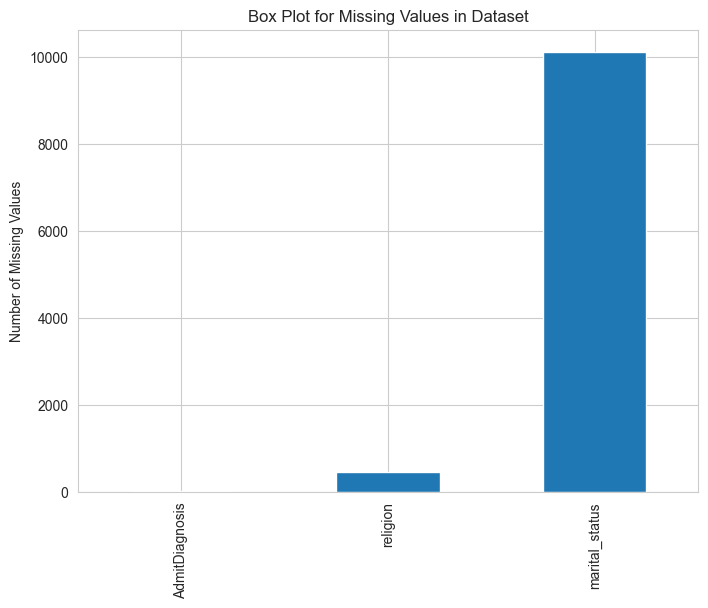

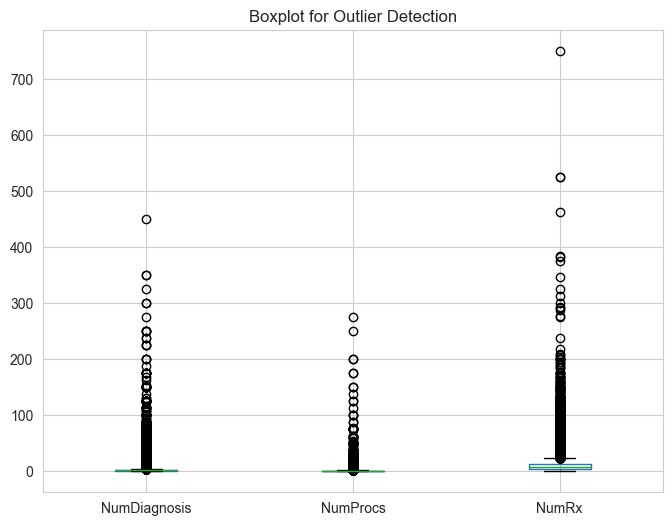

In [58]:
# Plot missing values
missing = df.isnull().sum()
plt.figure(figsize=(8, 6))
missing[missing > 0].plot(kind='bar')
plt.title('Box Plot for Missing Values in Dataset')
plt.ylabel('Number of Missing Values')
plt.show()

# Outlier detection with boxplots
plt.figure(figsize=(8, 6))
df[['NumDiagnosis', 'NumProcs', 'NumRx']].boxplot()
plt.title('Boxplot for Outlier Detection')
plt.show()


In [59]:
columns_to_check = ['NumDiagnosis', 'NumProcs', 'NumRx']

# Dictionary to hold the filtered dataframes for each column
filtered_dfs = {}

for column in columns_to_check:
    # Calculate Q1 and Q3
    Q1 = df[column].quantile(0.01)
    Q3 = df[column].quantile(0.99)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering the data without outliers
    condition = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    filtered_dfs[column] = df[condition]

no_outliers_df = df.copy()
for column, filtered_df in filtered_dfs.items():
    no_outliers_df = no_outliers_df[no_outliers_df.index.isin(filtered_df.index)]

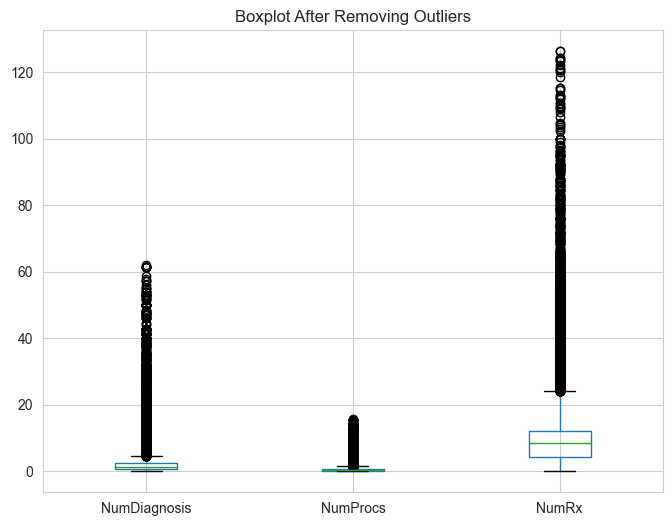

In [60]:
# Display the boxplot to check the result
plt.figure(figsize=(8,6))
no_outliers_df[columns_to_check].boxplot()
plt.title('Boxplot After Removing Outliers')
plt.show()


In [61]:
df=no_outliers_df
len(df)

58648

In [62]:
# Description of LOSgrpoupNum
grouped_descriptions = df.groupby('LOSgroupNum')['LOSdays'].describe()
print(grouped_descriptions)

               count       mean        std   min    25%    50%    75%     max
LOSgroupNum                                                                  
0            16290.0   2.394813   1.017537   0.0   1.79   2.46   3.21    3.96
1            18755.0   5.770912   1.171644   4.0   4.75   5.71   6.79    7.96
2             9342.0   9.764154   1.159247   8.0   8.79   9.71  10.75   11.96
3            14261.0  25.104990  17.828046  12.0  14.79  19.00  27.96  294.63


In [63]:
# Calculate the range of LOSdays for each group
group_ranges = df.groupby('LOSgroupNum')['LOSdays'].agg(['min', 'max'])
print(group_ranges)

              min     max
LOSgroupNum              
0             0.0    3.96
1             4.0    7.96
2             8.0   11.96
3            12.0  294.63


In [64]:
len(df["AdmitDiagnosis"].unique())

15645

In [65]:
# Calculate the mode of the column
mode_value = df['AdmitDiagnosis'].mode()[0]

# Replace missing values with the mode
df['AdmitDiagnosis'].fillna(mode_value, inplace=True)



C:\Users\yrrra\AppData\Local\Temp\ipykernel_20428\4086330667.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AdmitDiagnosis'].fillna(mode_value, inplace=True)


In [66]:
df

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,199993,M,60,24.58,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,DIVORCED,...,0.20,0.13,23.11,8.01,0.00,0.08,1315.46,0,1746.31,3
58972,199994,F,58,9.75,EMERGENCY,EMERGENCY ROOM ADMIT,MENTAL STATUS CHANGES,Medicare,CATHOLIC,SINGLE,...,2.26,0.30,7.90,0.00,0.00,0.31,674.05,0,834.98,2
58973,199995,M,23,16.75,EMERGENCY,PHYS REFERRAL/NORMAL DELI,ROOT ABSCESS,Private,PROTESTANT QUAKER,SINGLE,...,0.54,0.10,6.27,5.79,0.00,0.36,207.10,0,261.30,3
58974,199998,M,69,5.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Medicare,CATHOLIC,MARRIED,...,0.17,0.35,12.24,17.69,0.00,1.02,426.87,0,537.42,1


In [67]:
# Columns to drop
columns_to_drop = ["LOSdays", "hadm_id", "religion", "marital_status", "ethnicity"]

# Drop columns from the DataFrame
df = df.drop(columns_to_drop, axis=1)

# Check for Missing Values
missing_percentage(df)

gender              0.0
age                 0.0
admit_type          0.0
admit_location      0.0
AdmitDiagnosis      0.0
insurance           0.0
NumCallouts         0.0
NumDiagnosis        0.0
NumProcs            0.0
AdmitProcedure      0.0
NumCPTevents        0.0
NumInput            0.0
NumLabs             0.0
NumMicroLabs        0.0
NumNotes            0.0
NumOutput           0.0
NumRx               0.0
NumProcEvents       0.0
NumTransfers        0.0
NumChartEvents      0.0
ExpiredHospital     0.0
TotalNumInteract    0.0
LOSgroupNum         0.0
dtype: float64

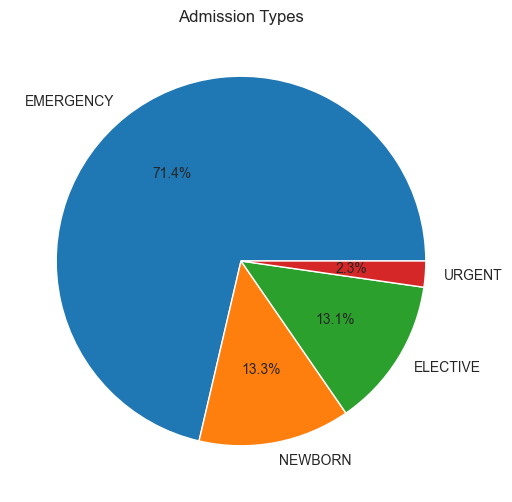

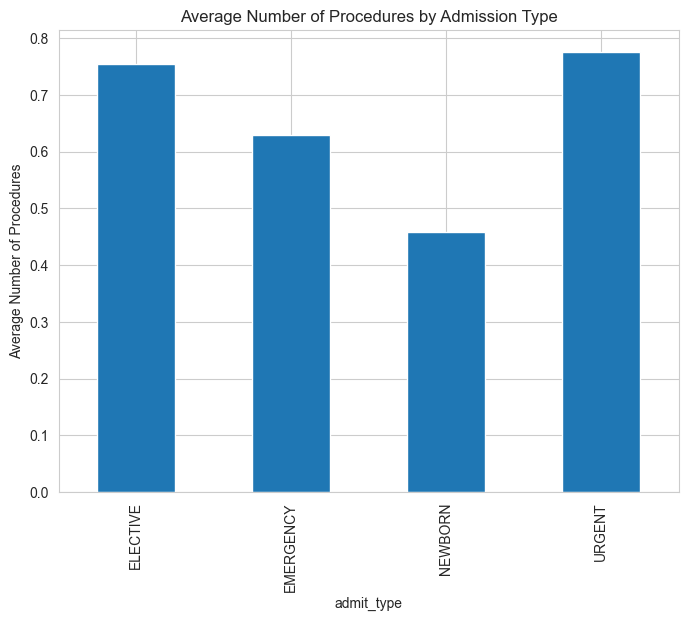

In [68]:
# Admission type counts
plt.figure(figsize=(8,6))
admit_type_counts = df['admit_type'].value_counts()
admit_type_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Admission Types')
plt.ylabel('')
plt.show()

# Average number of procedures by admission type
plt.figure(figsize=(8,6))
avg_procs_by_admit_type = df.groupby('admit_type')['NumProcs'].mean()
avg_procs_by_admit_type.plot(kind='bar')
plt.title('Average Number of Procedures by Admission Type')
plt.ylabel('Average Number of Procedures')
plt.show()


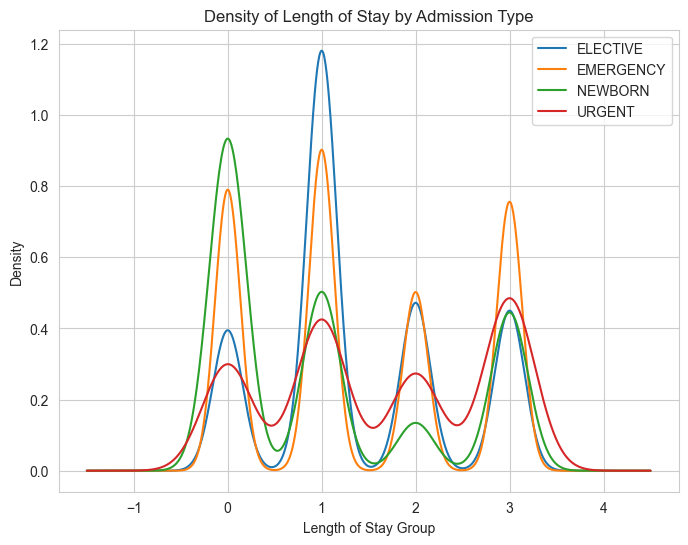

In [69]:
# Length of stay distribution by admit type
plt.figure(figsize=(8,6))
df.groupby('admit_type')['LOSgroupNum'].plot(kind='kde', legend=True)
plt.title('Density of Length of Stay by Admission Type')
plt.xlabel('Length of Stay Group')
plt.show()


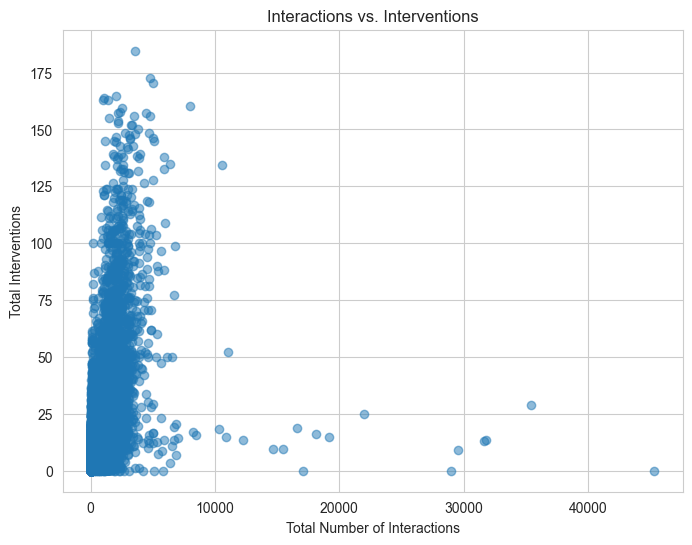

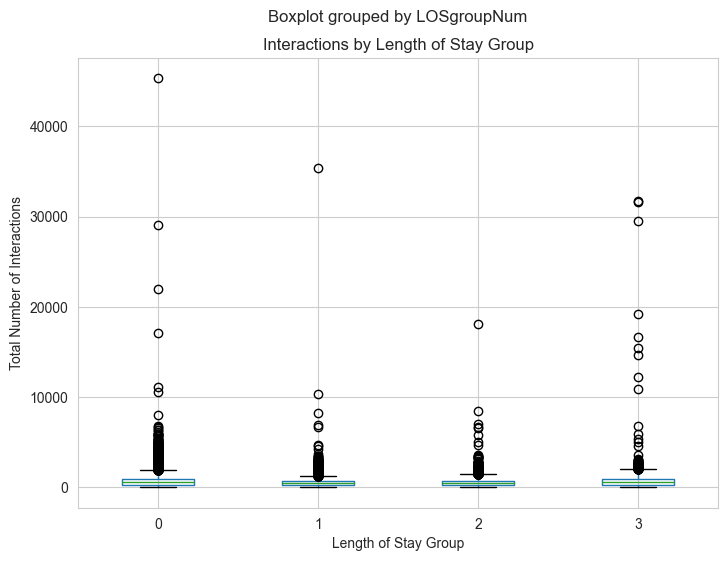

In [70]:
# Scatter plot of interactions vs. total interventions
plt.figure(figsize=(8,6))
df['TotalInterventions'] = df['NumProcs'] + df['NumRx'] + df['NumDiagnosis']
plt.scatter(df['TotalNumInteract'], df['TotalInterventions'], alpha=0.5)
plt.xlabel('Total Number of Interactions')
plt.ylabel('Total Interventions')
plt.title('Interactions vs. Interventions')
plt.show()

# Boxplot to see interaction levels by LOS group
df.boxplot(column='TotalNumInteract', by='LOSgroupNum', figsize=(8, 6))
plt.title('Interactions by Length of Stay Group')
plt.xlabel('Length of Stay Group')
plt.ylabel('Total Number of Interactions')
plt.show()


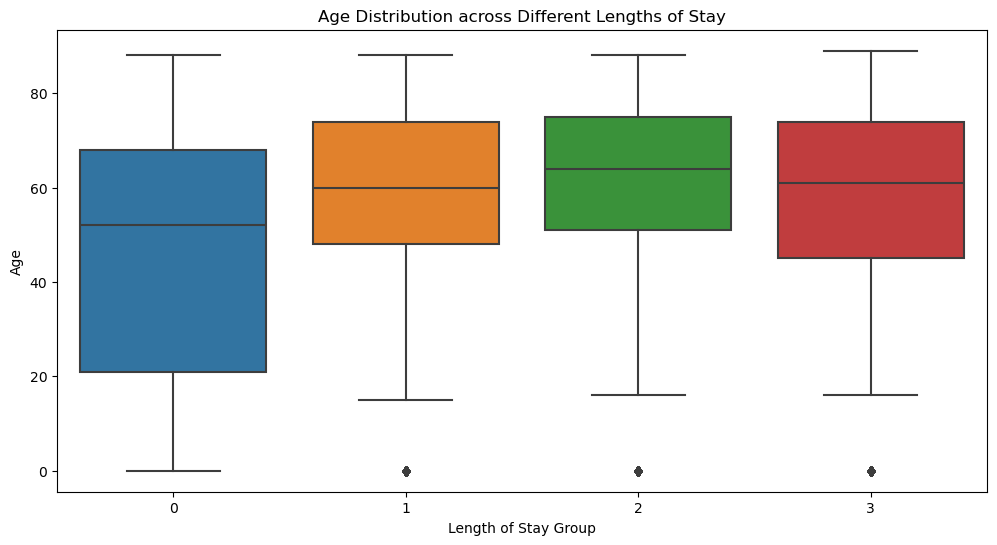

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of age and length of stay group
plt.figure(figsize=(12, 6))
sns.boxplot(x='LOSgroupNum', y='age', data=df)
plt.title('Age Distribution across Different Lengths of Stay')
plt.xlabel('Length of Stay Group')
plt.ylabel('Age')
plt.show()

In [71]:
columns_to_collapse = ['AdmitDiagnosis', 'AdmitProcedure']

for column in columns_to_collapse:
    # Identify the top 5 categories in the column
    top_categories = df[column].value_counts().nlargest(5).index
    
    # Replace categories not in the top 5 with 'Other'
    new_column_name = f"{column}_Collapsed"
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')

    # Print the value counts of the new column to verify
    print(f"Collapsed categories for {new_column_name}:")
    print(df[column].value_counts())
    print("\n")

Collapsed categories for AdmitDiagnosis_Collapsed:
AdmitDiagnosis
Other                       46389
NEWBORN                      7761
PNEUMONIA                    1562
SEPSIS                       1172
CONGESTIVE HEART FAILURE      925
CORONARY ARTERY DISEASE       839
Name: count, dtype: int64


Collapsed categories for AdmitProcedure_Collapsed:
AdmitProcedure
Other                       40974
na                           7981
Cont inv mec ven <96 hrs     3275
Vaccination NEC              2666
Venous cath NEC              1938
Insert endotracheal tube     1814
Name: count, dtype: int64




In [72]:
# Initialize LabelEncoder
label_encode = LabelEncoder()

In [73]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance',
       'AdmitProcedure'],
      dtype='object')

In [74]:
df[df.select_dtypes(include=['object']).columns].head(3)

,gender,admit_type,admit_location,AdmitDiagnosis,insurance,AdmitProcedure
0,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,Other,Private,na
1,M,EMERGENCY,EMERGENCY ROOM ADMIT,Other,Private,Other
2,F,EMERGENCY,EMERGENCY ROOM ADMIT,Other,Private,Other


In [75]:
# Apply label encoding to object columns
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(lambda x: label_encode.fit_transform(x))
df[['gender', 'admit_type', 'admit_location','AdmitDiagnosis', 'insurance',
       'AdmitProcedure']].head(3)

,gender,admit_type,admit_location,AdmitDiagnosis,insurance,AdmitProcedure
0,0,1,1,3,3,5
1,1,1,2,3,3,2
2,0,1,2,3,3,2


<Figure size 640x480 with 0 Axes>

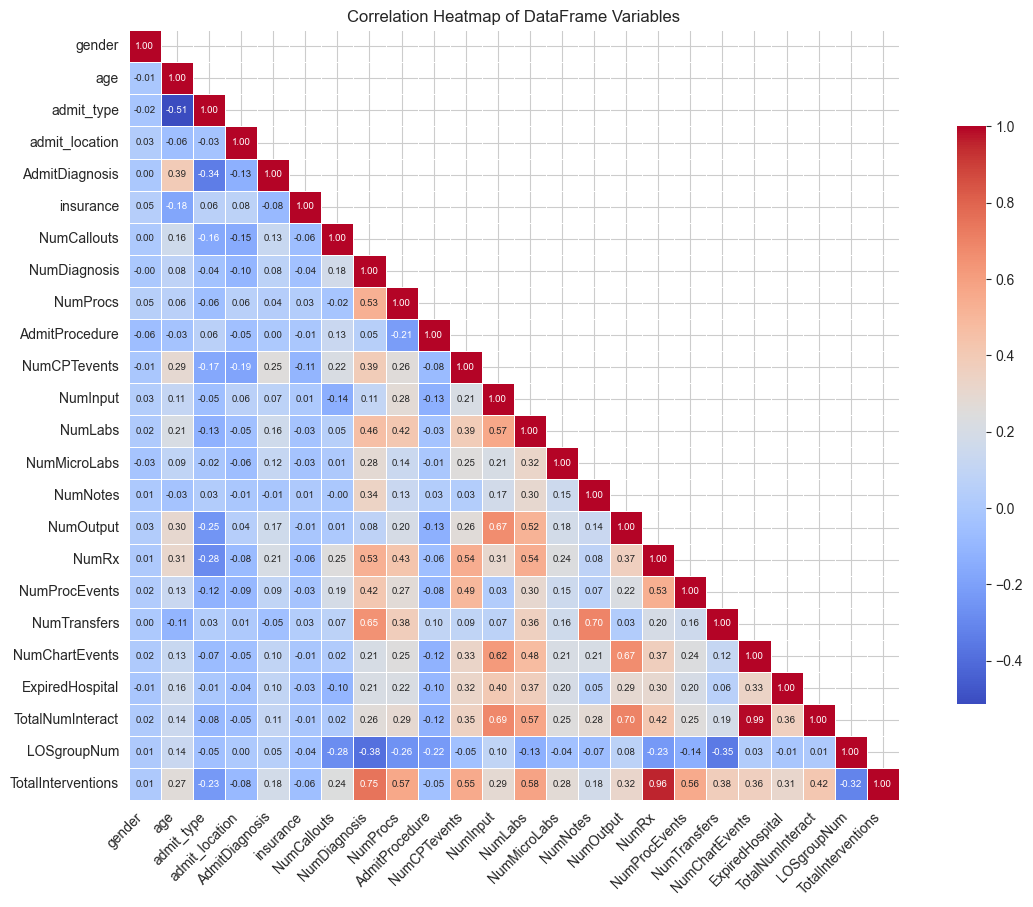

In [76]:
plt.clf()

# Calculate the correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask[np.diag_indices_from(mask)] = False

# Plot the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 7})  # Adjust size here

# Rotate the x and y axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Heatmap of DataFrame Variables')
plt.show()

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58648 entries, 0 to 58975
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              58648 non-null  int32  
 1   age                 58648 non-null  int64  
 2   admit_type          58648 non-null  int32  
 3   admit_location      58648 non-null  int32  
 4   AdmitDiagnosis      58648 non-null  int32  
 5   insurance           58648 non-null  int32  
 6   NumCallouts         58648 non-null  float64
 7   NumDiagnosis        58648 non-null  float64
 8   NumProcs            58648 non-null  float64
 9   AdmitProcedure      58648 non-null  int32  
 10  NumCPTevents        58648 non-null  float64
 11  NumInput            58648 non-null  float64
 12  NumLabs             58648 non-null  float64
 13  NumMicroLabs        58648 non-null  float64
 14  NumNotes            58648 non-null  float64
 15  NumOutput           58648 non-null  float64
 16  NumRx    

# Model Building

In [78]:
df.head(3)

,gender,age,admit_type,admit_location,AdmitDiagnosis,insurance,NumCallouts,NumDiagnosis,NumProcs,AdmitProcedure,...,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,TotalInterventions
0,0,35,1,1,3,3,0.16,2.59,0.00,5,...,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1,17.50
1,1,59,1,2,3,3,0.25,2.23,0.99,2,...,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1,10.40
2,0,48,1,2,3,3,0.00,0.75,0.17,2,...,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3,7.15


In [79]:
# Select the predictive features or the columns
df_target = df["LOSgroupNum"]
df_predictors = df.drop("LOSgroupNum", axis=1)


In [80]:
df_target

0        1
1        1
2        3
3        1
4        1
        ..
58971    3
58972    2
58973    3
58974    1
58975    1
Name: LOSgroupNum, Length: 58648, dtype: int64

In [81]:
df_predictors

,gender,age,admit_type,admit_location,AdmitDiagnosis,insurance,NumCallouts,NumDiagnosis,NumProcs,AdmitProcedure,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,TotalInterventions
0,0,35,1,1,3,3,0.16,2.59,0.00,5,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,17.50
1,1,59,1,2,3,3,0.25,2.23,0.99,2,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,10.40
2,0,48,1,2,3,3,0.00,0.75,0.17,2,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,7.15
3,0,73,1,2,3,3,0.41,0.69,0.27,2,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,12.48
4,1,60,1,5,1,3,0.00,3.69,0.82,2,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,29.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,1,60,1,5,1,3,0.00,0.37,0.53,2,...,0.20,0.13,23.11,8.01,0.00,0.08,1315.46,0,1746.31,8.91
58972,0,58,1,2,3,2,0.00,0.92,0.41,0,...,2.26,0.30,7.90,0.00,0.00,0.31,674.05,0,834.98,1.33
58973,1,23,1,4,3,3,0.00,0.60,0.54,2,...,0.54,0.10,6.27,5.79,0.00,0.36,207.10,0,261.30,6.93
58974,1,69,1,5,1,2,0.00,2.72,0.51,2,...,0.17,0.35,12.24,17.69,0.00,1.02,426.87,0,537.42,20.92


In [82]:
# Train the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(df_predictors, df_target)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': df_predictors.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
18,NumTransfers,0.740226
6,NumCallouts,0.070565
14,NumNotes,0.065065
7,NumDiagnosis,0.037609
21,TotalNumInteract,0.010920
13,NumMicroLabs,0.008745
22,TotalInterventions,0.006853
19,NumChartEvents,0.006708
1,age,0.006565
11,NumInput,0.006254


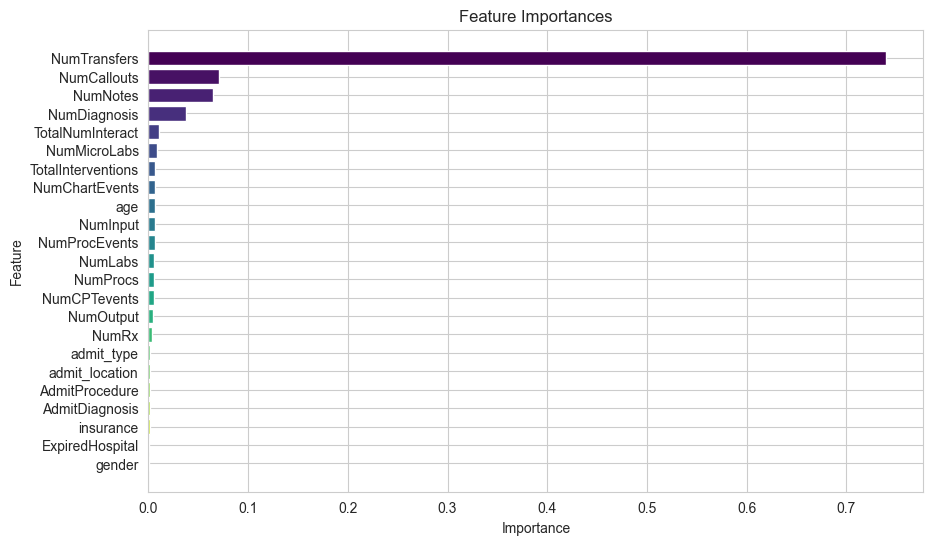

In [83]:
# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar chart
ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)

# Set labels and title
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances')

# Invert y-axis for better visualization
ax.invert_yaxis()

# Show plot
plt.show()

In [84]:
# Select top features
top_n = 16
top_features = feature_importance_df.head(top_n)['Feature'].tolist()

# Filter the predictors DataFrame to include only the top features
df_top_predictors = df_predictors[top_features]
top_features

['NumTransfers',
 'NumCallouts',
 'NumNotes',
 'NumDiagnosis',
 'TotalNumInteract',
 'NumMicroLabs',
 'TotalInterventions',
 'NumChartEvents',
 'age',
 'NumInput',
 'NumProcEvents',
 'NumLabs',
 'NumProcs',
 'NumCPTevents',
 'NumOutput',
 'NumRx']

In [85]:
df_top_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58648 entries, 0 to 58975
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NumTransfers        58648 non-null  float64
 1   NumCallouts         58648 non-null  float64
 2   NumNotes            58648 non-null  float64
 3   NumDiagnosis        58648 non-null  float64
 4   TotalNumInteract    58648 non-null  float64
 5   NumMicroLabs        58648 non-null  float64
 6   TotalInterventions  58648 non-null  float64
 7   NumChartEvents      58648 non-null  float64
 8   age                 58648 non-null  int64  
 9   NumInput            58648 non-null  float64
 10  NumProcEvents       58648 non-null  float64
 11  NumLabs             58648 non-null  float64
 12  NumProcs            58648 non-null  float64
 13  NumCPTevents        58648 non-null  float64
 14  NumOutput           58648 non-null  float64
 15  NumRx               58648 non-null  float64
dtypes: float6

In [86]:
missing_percentage(df)

gender                0.0
age                   0.0
admit_type            0.0
admit_location        0.0
AdmitDiagnosis        0.0
insurance             0.0
NumCallouts           0.0
NumDiagnosis          0.0
NumProcs              0.0
AdmitProcedure        0.0
NumCPTevents          0.0
NumInput              0.0
NumLabs               0.0
NumMicroLabs          0.0
NumNotes              0.0
NumOutput             0.0
NumRx                 0.0
NumProcEvents         0.0
NumTransfers          0.0
NumChartEvents        0.0
ExpiredHospital       0.0
TotalNumInteract      0.0
LOSgroupNum           0.0
TotalInterventions    0.0
dtype: float64

In [87]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_top_predictors, df_target, test_size=0.2, random_state=42)

In [88]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [89]:
# Model Initialization
models = {
    'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=len(df_target.unique())),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=8),
    'SVM': SVC()
}

# Initialize empty dictionaries to store metrics
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}
mcc_dict = {}
kappa_dict = {}
balanced_accuracy_dict = {}

# Train and Evaluate the models
for name, model in models.items():
    
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    mcc = matthews_corrcoef(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)

    # Store metrics in dictionaries
    accuracy_dict[name] = accuracy
    precision_dict[name] = precision
    recall_dict[name] = recall
    f1_dict[name] = f1
    mcc_dict[name] = mcc
    kappa_dict[name] = kappa
    balanced_accuracy_dict[name] = balanced_accuracy

C:\Users\yrrra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
# Metrics for XGBoost
print("Metrics for XGBoost:")
print("Accuracy:", accuracy_dict['XGBoost'])
print("Precision:", precision_dict['XGBoost'])
print("Recall:", recall_dict['XGBoost'])
print("F1-score:", f1_dict['XGBoost'])
print("MCC:", mcc_dict['XGBoost'])
print("Cohen's Kappa:", kappa_dict['XGBoost'])
print("Balanced Accuracy:", balanced_accuracy_dict['XGBoost'], "\n")

# Metrics for Random Forest
print("Metrics for Random Forest:")
print("Accuracy:", accuracy_dict['Random Forest'])
print("Precision:", precision_dict['Random Forest'])
print("Recall:", recall_dict['Random Forest'])
print("F1-score:", f1_dict['Random Forest'])
print("MCC:", mcc_dict['Random Forest'])
print("Cohen's Kappa:", kappa_dict['Random Forest'])
print("Balanced Accuracy:", balanced_accuracy_dict['Random Forest'], "\n")

# Metrics for Decision Tree
print("Metrics for Decision Tree:")
print("Accuracy:", accuracy_dict['Decision Tree'])
print("Precision:", precision_dict['Decision Tree'])
print("Recall:", recall_dict['Decision Tree'])
print("F1-score:", f1_dict['Decision Tree'])
print("MCC:", mcc_dict['Decision Tree'])
print("Cohen's Kappa:", kappa_dict['Decision Tree'])
print("Balanced Accuracy:", balanced_accuracy_dict['Decision Tree'], "\n")

# Metrics for KNN
print("Metrics for KNN:")
print("Accuracy:", accuracy_dict['KNN'])
print("Precision:", precision_dict['KNN'])
print("Recall:", recall_dict['KNN'])
print("F1-score:", f1_dict['KNN'])
print("MCC:", mcc_dict['KNN'])
print("Cohen's Kappa:", kappa_dict['KNN'])
print("Balanced Accuracy:", balanced_accuracy_dict['KNN'], "\n")

# Metrics for SVM
print("Metrics for SVM:")
print("Accuracy:", accuracy_dict['SVM'])
print("Precision:", precision_dict['SVM'])
print("Recall:", recall_dict['SVM'])
print("F1-score:", f1_dict['SVM'])
print("MCC:", mcc_dict['SVM'])
print("Cohen's Kappa:", kappa_dict['SVM'])
print("Balanced Accuracy:", balanced_accuracy_dict['SVM'], "\n")


Metrics for XGBoost:
Accuracy: 0.935464620630861
Precision: 0.9316452819080088
Recall: 0.9235625620164535
F1-score: 0.9272394836692885
MCC: 0.912239719455569
Cohen's Kappa: 0.912054594151861
Balanced Accuracy: 0.9235625620164535 

Metrics for Random Forest:
Accuracy: 0.9084398976982098
Precision: 0.9044831096918765
Recall: 0.8907069188335786
F1-score: 0.8964336845130265
MCC: 0.875510575866781
Cohen's Kappa: 0.8749880202831466
Balanced Accuracy: 0.8907069188335786 

Metrics for Decision Tree:
Accuracy: 0.8689684569479966
Precision: 0.856912497391633
Recall: 0.8562626437233691
F1-score: 0.8565744184965092
MCC: 0.8218625120552975
Cohen's Kappa: 0.8218576201598291
Balanced Accuracy: 0.8562626437233691 

Metrics for KNN:
Accuracy: 0.5183290707587382
Precision: 0.48969654926614103
Recall: 0.4807438022193724
F1-score: 0.4812167552202459
MCC: 0.3391548654711293
Cohen's Kappa: 0.33701001857196256
Balanced Accuracy: 0.4807438022193724 

Metrics for SVM:
Accuracy: 0.4837169650468883
Precision: 0.

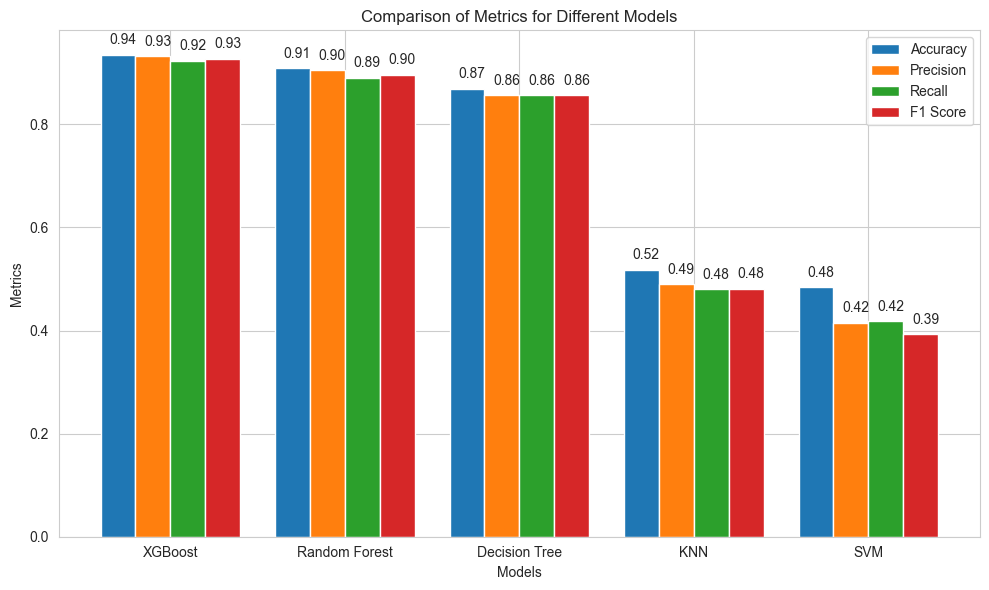

In [91]:
# Models
models = list(accuracy_dict.keys())

# Metrics
accuracy = list(accuracy_dict.values())
precision = list(precision_dict.values())
recall = list(recall_dict.values())
f1 = list(f1_dict.values())

# Plotting
bar_width = 0.2
index = range(len(models))

# Set figure size
plt.figure(figsize=(10, 6))

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], precision, bar_width, label='Precision')
plt.bar([i + 2 * bar_width for i in index], recall, bar_width, label='Recall')
plt.bar([i + 3 * bar_width for i in index], f1, bar_width, label='F1 Score')

for i, value in enumerate(accuracy + precision + recall + f1):
    plt.text(i % len(models) + (i // len(models)) * bar_width - 0.05, value + 0.02, "{:.2f}".format(value), fontsize=10)

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Comparison of Metrics for Different Models')
plt.xticks([i + 1.5 * bar_width for i in index], models)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [92]:
model_order = ['XGBoost', 'Random Forest', 'Decision Tree', 'KNN', 'SVM']

# Creating a DataFrame from the metrics dictionaries
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_dict,
    'Precision': precision_dict,
    'Recall': recall_dict,
    'F1 Score': f1_dict,
    'MCC': mcc_dict,
    'Cohen\'s Kappa': kappa_dict,
    'Balanced Accuracy': balanced_accuracy_dict
})
metrics_df = metrics_df.reindex(model_order)

# Display the DataFrame
print(metrics_df)

               Accuracy  Precision    Recall  F1 Score       MCC  \
XGBoost        0.935465   0.931645  0.923563  0.927239  0.912240   
Random Forest  0.908440   0.904483  0.890707  0.896434  0.875511   
Decision Tree  0.868968   0.856912  0.856263  0.856574  0.821863   
KNN            0.518329   0.489697  0.480744  0.481217  0.339155   
SVM            0.483717   0.415078  0.417620  0.392815  0.295822   

               Cohen's Kappa  Balanced Accuracy  
XGBoost             0.912055           0.923563  
Random Forest       0.874988           0.890707  
Decision Tree       0.821858           0.856263  
KNN                 0.337010           0.480744  
SVM                 0.264319           0.417620  


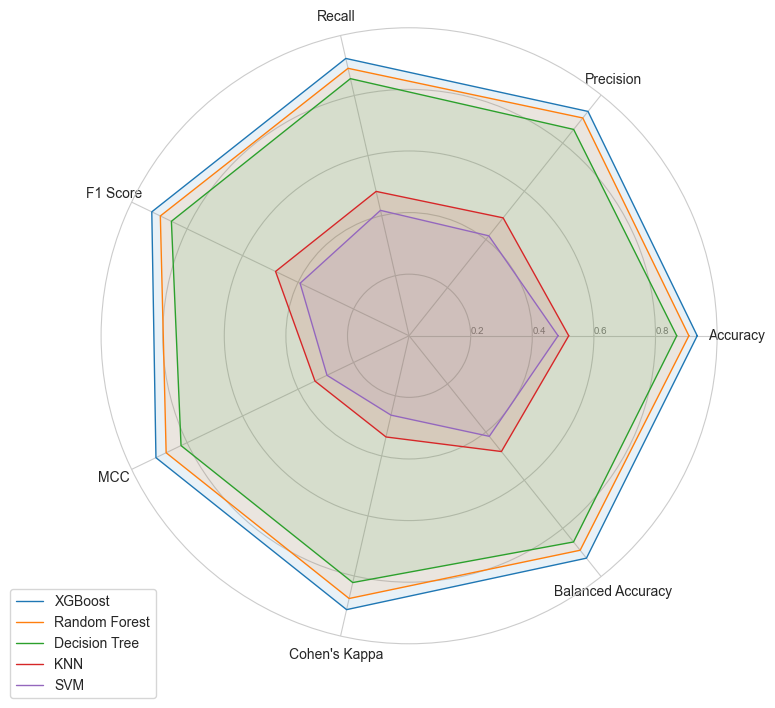

In [93]:
categories = list(metrics_df.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0,1)

# Plot each model
for index, row in metrics_df.iterrows():
    data = row.tolist()
    data += data[:1]
    ax.plot(angles, data, linewidth=1, linestyle='solid', label=index)
    ax.fill(angles, data, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


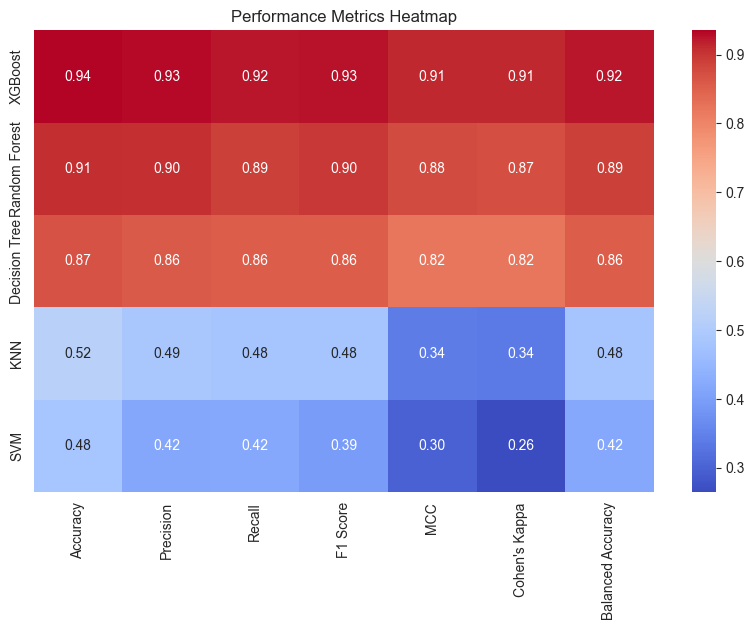

In [94]:
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Performance Metrics Heatmap')
plt.show()